In [378]:
import cv2 as cv
from matplotlib import pyplot as plt
import json
import numpy as np
import os

In [379]:
config = json.load(open("../config.json"))
print(config)
antrenare_folder = "../../antrenare/"
evaluare_folder = "../../evaluare/"
auxiliare_folder = "../../imagini_auxiliare/"

{'base_image_path': '../imagini_auxiliare/01.jpg', 'score_tracker': [1, 2, 3, 4, 5, 6, 0, 2, 5, 3, 4, 6, 2, 2, 0, 3, 5, 4, 1, 6, 2, 4, 5, 5, 0, 6, 3, 4, 2, 0, 1, 5, 1, 3, 4, 4, 4, 5, 0, 6, 3, 5, 4, 1, 3, 2, 0, 0, 1, 1, 2, 3, 6, 3, 5, 2, 1, 0, 6, 6, 5, 2, 1, 2, 5, 0, 3, 3, 5, 0, 6, 1, 4, 0, 6, 3, 5, 1, 4, 2, 6, 2, 3, 1, 6, 5, 6, 2, 0, 4, 0, 1, 6, 4, 4, 1, 6, 6, 3, 100], 'board': [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0,

In [380]:
def show_image(image):
    image = cv.resize(image, (0, 0), fx=0.3, fy=0.3)
    cv.imshow("image", image)
    cv.waitKey(0)
    cv.destroyAllWindows()


def print_image(image, gray=True, fft=True, title=None, output_dir=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    if not gray:
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        axes[0].imshow(image_rgb)
        image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        axes[0].imshow(image, cmap="gray")
        image_gray = image
    axes[0].set_title("Image")
    axes[0].axis("off")

    if fft:
        f = np.fft.fft2(image_gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-60)
        axes[1].imshow(magnitude_spectrum, cmap="gray")
        axes[1].set_title("Spectrum")
        axes[1].axis("off")
    else:
        axes[1].remove()

    if title:
        plt.suptitle(title)
    plt.tight_layout()

    if output_dir:
        plt.savefig(output_dir)
    else:
        plt.show()


def color_filter(image, color_rgb, sensitivity):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    color_hsv = cv.cvtColor(color_rgb, cv.COLOR_RGB2HSV)
    h, s, v = color_hsv[0][0]
    lower_bound = np.array(
        [h - sensitivity, max(s - sensitivity, 0), max(v - sensitivity, 0)]
    )
    upper_bound = np.array(
        [h + sensitivity, min(s + sensitivity, 255), min(v + sensitivity, 255)]
    )

    mask = cv.inRange(hsv, lower_bound, upper_bound)
    filtered_image = cv.bitwise_and(image, image, mask=mask)
    return filtered_image


def find_largest_contour(mask):
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(mask, 1, 255, cv.THRESH_BINARY)
    binary = cv.morphologyEx(
        binary, cv.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=20
    )
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        return max(contours, key=cv.contourArea)
    return None


def crop_board(image):
    mask = color_filter(image, color_rgb=np.uint8([[[11, 143, 171]]]), sensitivity=60)
    largest_contour = find_largest_contour(mask)
    if largest_contour is None:
        return None

    x, y, w, h = cv.boundingRect(largest_contour)
    tightness = 20

    x, y, w, h = x - tightness, y - tightness, w + 2 * tightness, h + 2 * tightness
    top_left = (x, y)
    bottom_right = (x + w, y + h)
    top_right = (x + w, y)
    bottom_left = (x, y + h)
    orig = np.array(
        [[top_left], [top_right], [bottom_right], [bottom_left]], dtype="float32"
    )
    dest = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype="float32")
    m = cv.getPerspectiveTransform(orig, dest)
    return cv.warpPerspective(image, m, (w, h))


base_img = cv.imread("./tabla_negoala.jpg")
# base_img = cv.imread(antrenare_folder + "2_01.jpg")

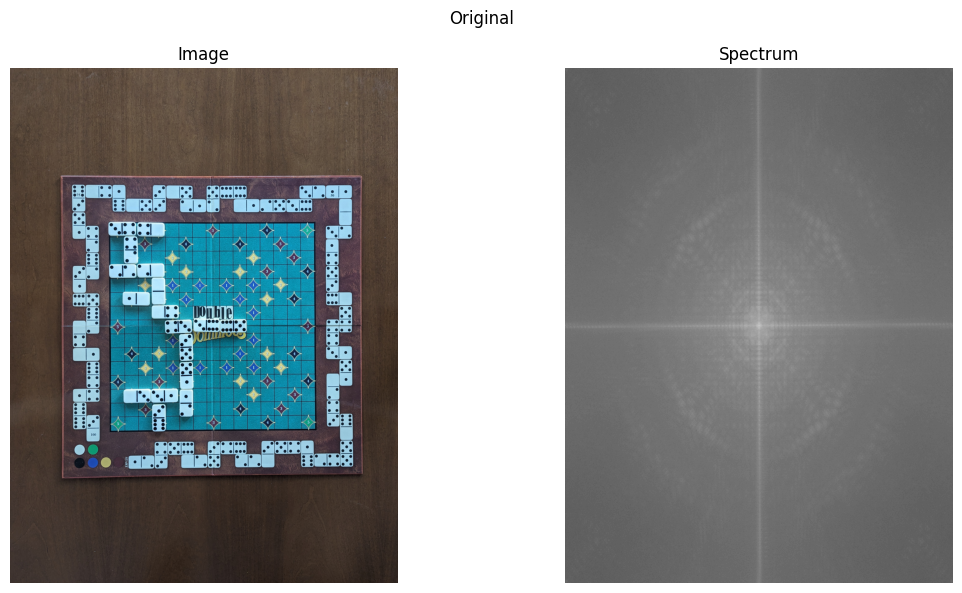

In [381]:
# original
image = base_img.copy()
print_image(image, gray=False, title="Original")

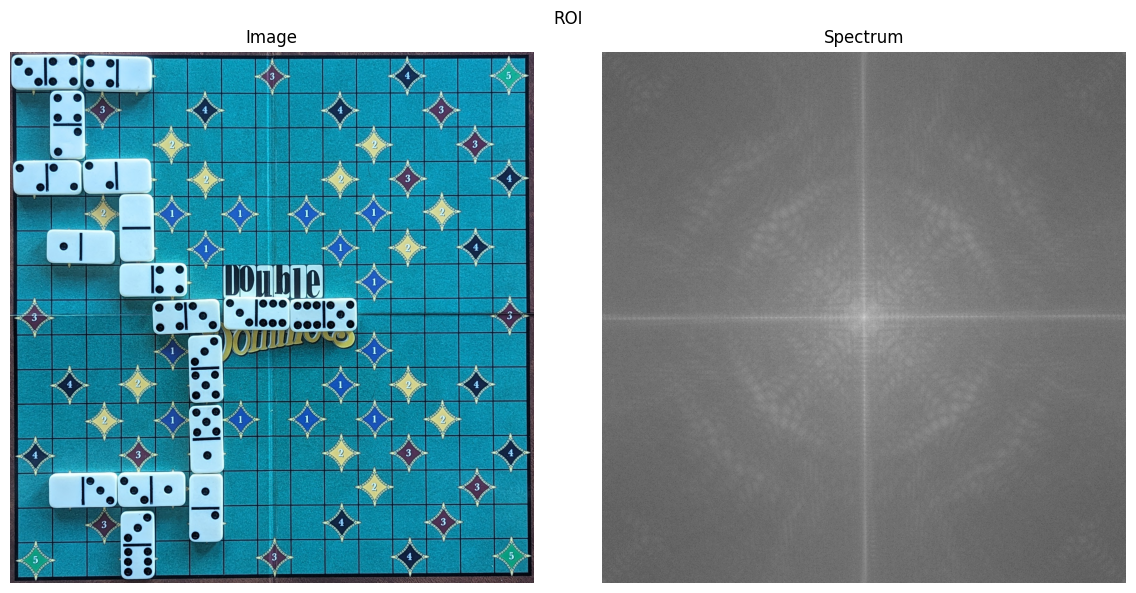

In [382]:
image = base_img.copy()

roi = crop_board(image)
print_image(roi, gray=False, title="ROI")

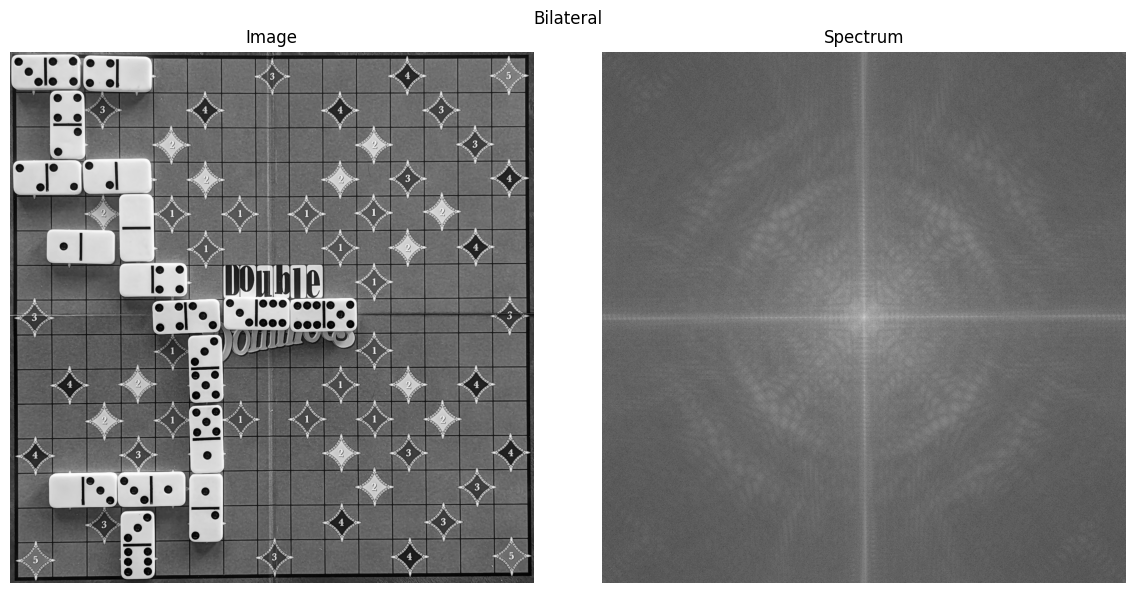

In [383]:
image = roi.copy()


def denoise(image):
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_blurred = image_gray
    # image_blurred = cv.GaussianBlur(
    #     image_gray, ksize=(5, 5), sigmaX=1, borderType=cv.BORDER_REPLICATE
    # )
    # print_image(image_blurred, title="Gaussian")

    image_blurred = cv.bilateralFilter(
        image_blurred,
        d=9,
        sigmaColor=15,
        sigmaSpace=150,
        borderType=cv.BORDER_REPLICATE,
    )
    return image_blurred


image_blurred = denoise(image)
print_image(image_blurred, title="Bilateral")

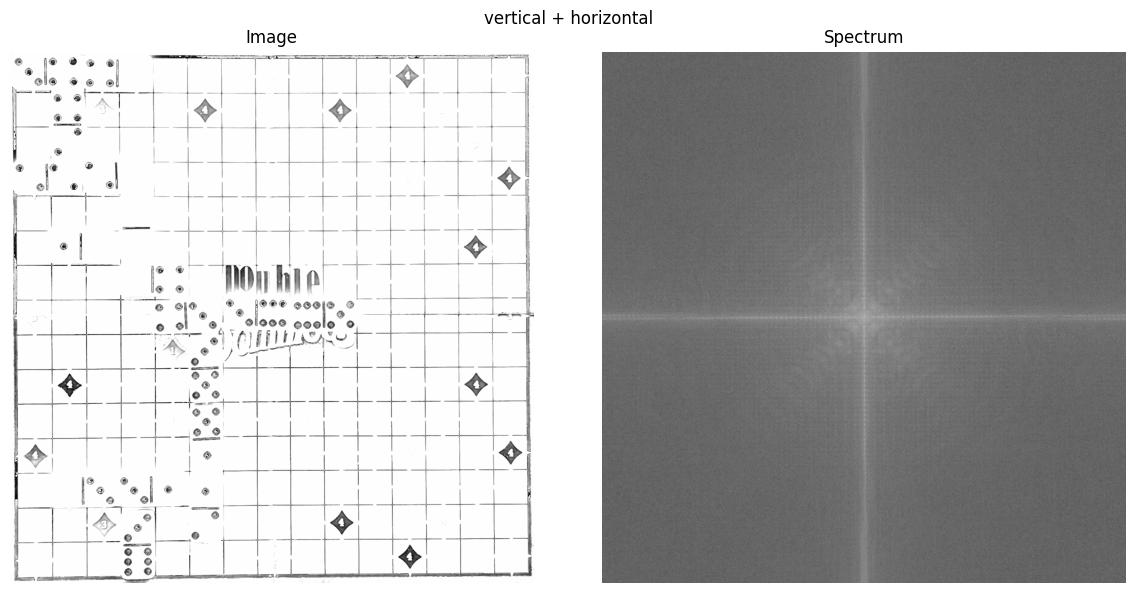

In [384]:
image = image_blurred.copy()


def sharpen(image):
    kernel_h = np.array(
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
        ],
        dtype=np.uint8,
    )

    kernel_v = np.array(
        [
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        dtype=np.uint8,
    )

    image_h = cv.filter2D(image, -1, kernel_h)
    image_v = cv.filter2D(image, -1, kernel_v)

    # print_image(image_h, title="vertical")
    # print_image(image_v, title="horizontal")

    image_sharpened = image_h + image_v
    return image_sharpened


image_sharpened = sharpen(image)
print_image(image_sharpened, title="vertical + horizontal")

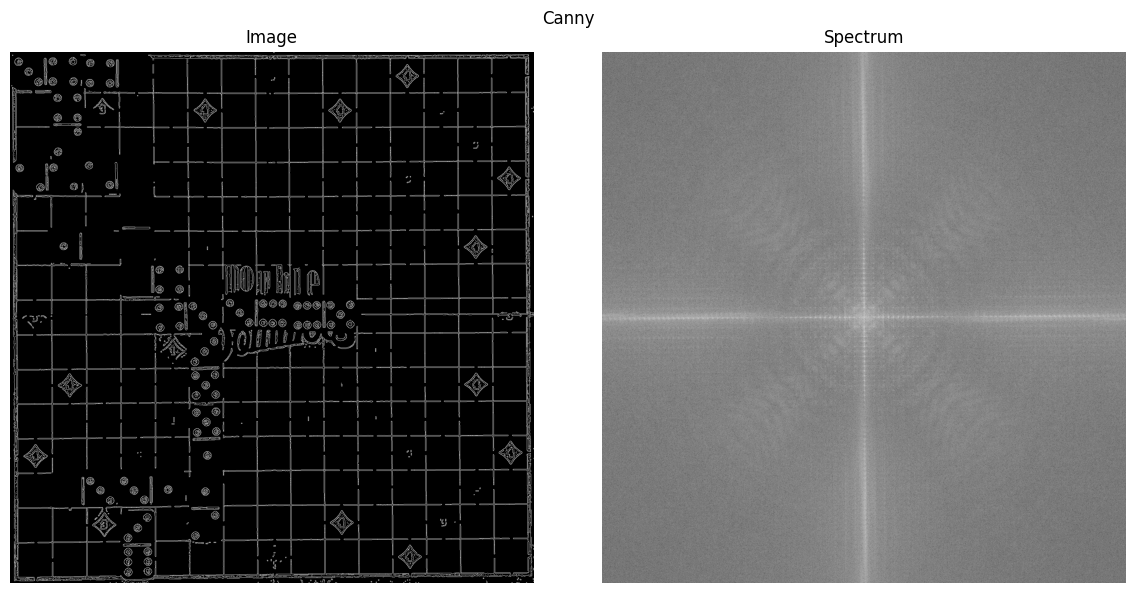

In [385]:
image = image_sharpened.copy()


def edge_detect(image):
    image_edges = cv.Canny(
        image=image,
        threshold1=100,
        threshold2=255,
        apertureSize=5,
        L2gradient=True,
    )
    return image_edges


image_edges = edge_detect(image)
print_image(image_edges, title="Canny")

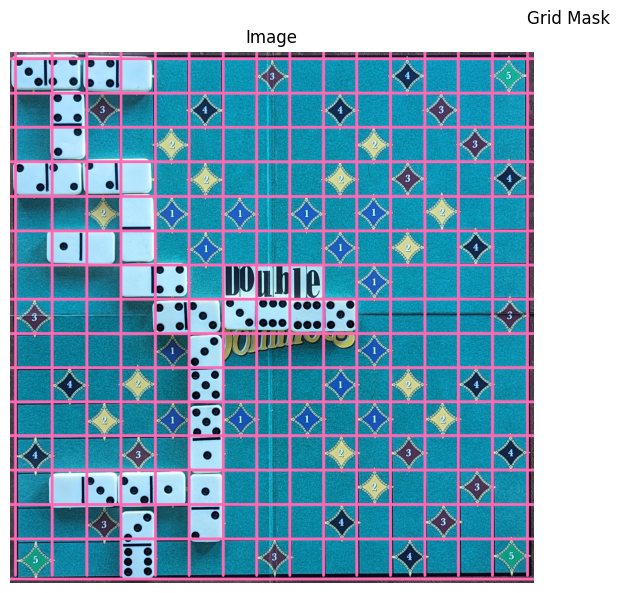

In [386]:
image = image_edges.copy()


def grid_mask(image):
    lines = cv.HoughLines(image, 1, np.pi / 180, 350)
    mask = np.zeros_like(image)
    width, height = mask.shape

    def cluster_lines(lines, rho_tolerance=10):
        if not lines:
            return []

        lines = sorted(lines, key=lambda x: x[0])

        clusters = []
        current_cluster = [lines[0]]
        for i in range(1, len(lines)):
            if abs(lines[i][0] - current_cluster[-1][0]) <= rho_tolerance:
                current_cluster.append(lines[i])
            else:
                clusters.append(current_cluster)
                current_cluster = [lines[i]]
        if current_cluster:
            clusters.append(current_cluster)
        averaged_lines = [
            (np.mean([line[0] for line in cluster]), cluster[0][1])
            for cluster in clusters
        ]

        return averaged_lines

    def insert_missing_lines(lines):
        lines = sorted(lines, key=lambda x: x[0])

        spacings = np.diff([line[0] for line in lines])
        mean_spacing = np.mean(spacings)

        new_lines = []
        for index, spacing in enumerate(spacings):
            if spacing > mean_spacing * 1.5:
                new_rho = (lines[index][0] + lines[index + 1][0]) / 2
                new_lines.append((new_rho, lines[index][1]))

        for new_line in new_lines:
            lines.append(new_line)
        lines = sorted(lines, key=lambda x: x[0])
        return lines

    def filter_lines(lines, tolerance=np.pi / 180, rho_tolerance=50):
        filtered_lines = {"vertical": [], "horizontal": []}

        for line in lines:
            for rho, theta in line:
                if abs(theta) < tolerance or abs(theta - np.pi) < tolerance:
                    filtered_lines["vertical"].append((rho, theta))
                elif abs(theta - np.pi / 2) < tolerance:
                    filtered_lines["horizontal"].append((rho, theta))

        filtered_lines["vertical"] = cluster_lines(
            filtered_lines["vertical"], rho_tolerance
        )
        filtered_lines["horizontal"] = cluster_lines(
            filtered_lines["horizontal"], rho_tolerance
        )
        filtered_lines["vertical"] = insert_missing_lines(filtered_lines["vertical"])
        filtered_lines["horizontal"] = insert_missing_lines(
            filtered_lines["horizontal"]
        )
        return filtered_lines

    def draw_lines(image, lines):
        for rho, theta in lines:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + width * (-b))
            y1 = int(y0 + height * (a))
            x2 = int(x0 - width * (-b))
            y2 = int(y0 - height * (a))
            cv.line(image, (x1, y1), (x2, y2), (255, 255, 255), 8)

    filtered_lines = filter_lines(lines)
    draw_lines(mask, filtered_lines["vertical"])
    draw_lines(mask, filtered_lines["horizontal"])
    return mask, filtered_lines


def draw_grid(image, mask, title=None, output_dir=None):
    pink = [180, 105, 255]
    pink_overlay = np.full_like(image, pink)
    overlayed_image = np.where(mask[:, :, None] == 255, pink_overlay, image)
    print_image(
        overlayed_image, gray=False, title=title, output_dir=output_dir, fft=False
    )


mask, _ = grid_mask(image)
draw_grid(roi.copy(), mask, title="Grid Mask")

(1684, 1660)


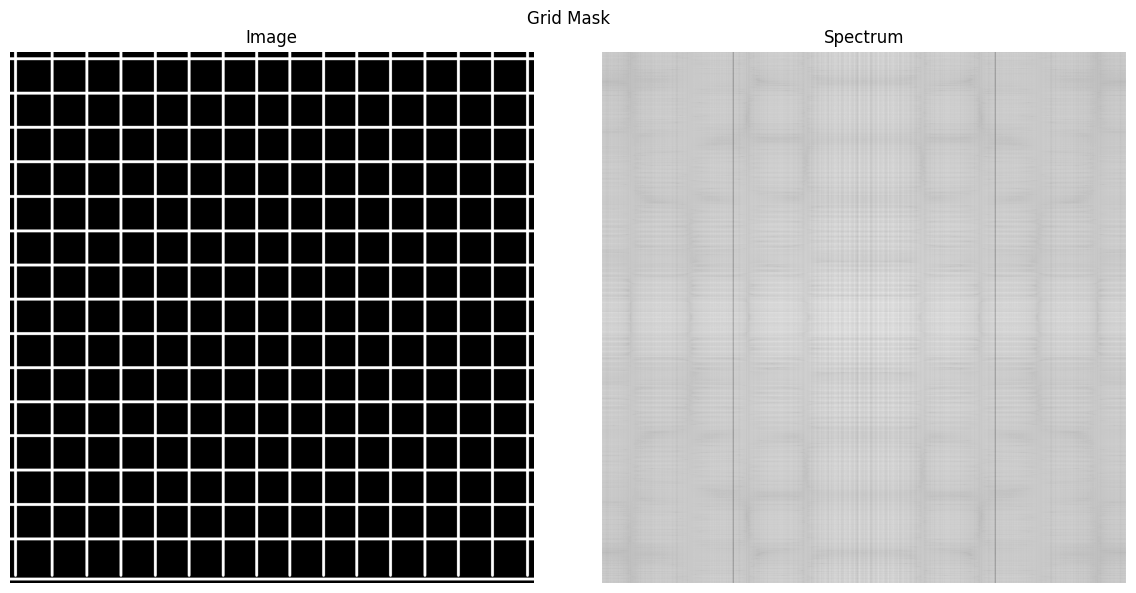

In [391]:
print(np.shape(mask))
print_image(mask, title="Grid Mask")

In [387]:
# image_paths = [f for f in os.listdir(antrenare_folder) if f.endswith("01.jpg")]


# for image_path in image_paths:
#     image = cv.imread(antrenare_folder + image_path)
#     roi = crop_board(image)
#     image_blurred = denoise(roi)
#     image_sharpened = sharpen(image_blurred)
#     image_edges = edge_detect(image_sharpened)
#     mask = grid_mask(image_edges)

#     draw_grid(
#         roi,
#         mask,
#         title=image_path,
#     )